In [1]:
import ROOT
import math
# Colors
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from root_numpy import root2array, tree2array
from root_numpy import testdata, fill_hist
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (recall_score,  precision_score, f1_score, roc_auc_score, precision_recall_curve,
                             make_scorer, confusion_matrix, accuracy_score, roc_curve)
from keras import backend as K
from imblearn.over_sampling import SMOTE, ADASYN
#https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

from time import time
from keras.callbacks import TensorBoard
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Welcome to JupyROOT 6.20/04


Using TensorFlow backend.


## TensorBoard

In [2]:
#https://www.youtube.com/watch?v=2U6Jl7oqRkM
#serve stats
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

## Count signal from background per region

In [3]:
#john style
signal = "1000"
desired_sig = "Xtohh1000"
file = f"../processed_data/all_{signal}.root" #file with data
rfile = ROOT.TFile(file) #root file
intree = rfile.Get("Nominal") #get tree from root file
df = pd.DataFrame(tree2array(intree)) #DataFrame from array from root file
df = df[df["sample"] != "data"][["m_region", "sample", "EventNumber"]] #take what we need
sample_count = df.groupby(['sample', 'm_region']).count() #group by sample and m region and count values
signal_count = sample_count.loc[desired_sig].rename(columns={'EventNumber': desired_sig}) #get desired signal values
bkg_count =  sample_count.drop([desired_sig]).groupby(['m_region']).sum().rename(columns={'EventNumber': 'background'}) #sum all the other signal counts, they are background
total_count = pd.concat([signal_count, bkg_count], axis = 1)
total_count

,Xtohh1000,background
m_region,,
PreSel_0tag,2550,98061
PreSel_1tag,4681,16467
PreSel_2tag,4343,995
QCDCR_0tag,557,38603
QCDCR_1tag,1128,7205
QCDCR_2tag,1166,556
SR_0tag,1993,59458
SR_1tag,3553,9262
SR_2tag,3177,439


In [4]:
#other style
# If the row sample is 'Xtohh1000' or 'Xtohh2000', then the new columns will have a 1 in this row.
def classifier(row):
    if row['sample'] == 'Xtohh1000':
        return 1
    #else if row['sample'] == 'Xtohh2000':
    #    return 1
    else:
        return 0

In [5]:
def sel_df(df, region):
    df = df[(df['sample']!='data') & (df['m_region']==region)]
    df["signal"] = df.apply(classifier, axis=1)
    return df

In [7]:
data_folder = "../processed_data/"
sig = "1000"
def print_configs():
    f = f"all_{sig}.root"
    rfile = ROOT.TFile(data_folder+f)
    intree = rfile.Get("Nominal")
    array = tree2array(intree)
    df = pd.DataFrame(array)
    print("File:",f)
    print('%-15s%-10s%-10s%-10s' % ("Region", "Xtohh", "Signal", "Bkg"))
    for reg in np.unique(df['m_region'].values):
        df_aux = sel_df(df, reg)
        bkg, signal = df_aux["signal"].value_counts().values
        print('%-15s%-10s%-10i%-10i' % (reg, sig, signal, bkg))

print_configs()

File: all_1000.root
Region         Xtohh     Signal    Bkg       
PreSel_0tag    1000      2550      98061     
PreSel_1tag    1000      4681      16467     
PreSel_2tag    1000      995       4343      
QCDCR_0tag     1000      557       38603     
QCDCR_1tag     1000      1128      7205      
QCDCR_2tag     1000      556       1166      
SR_0tag        1000      1993      59458     
SR_1tag        1000      3553      9262      
SR_2tag        1000      439       3177      


## DataFrame of SR_1tag

In [8]:
def get_data(file):
    rfile = ROOT.TFile(file)
    intree = rfile.Get("Nominal")
    df = pd.DataFrame(tree2array(intree))
    return df

In [9]:
def classify(signal, df):
    df = df[df["sample"] != "data"]
    df["signal"] = (df["sample"] == signal).astype(int)
    return df

In [11]:
#john style
signal = "Xtohh1000"
file = f"../processed_data/all_1000.root" #file with data
df = get_data(file)

#get data from region
df = df[df["m_region"] == "SR_1tag"]
#classify between signal and background
df = classify(signal, df)
weights = df["EventWeight"].values
df

,sample,EventWeight,EventNumber,m_region,m_FJNbtagJets,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt,signal
157,fakes,3.687500e-03,2344670999,SR_1tag,1,371.481293,0.778357,-0.930364,10326.322266,514.951416,-0.833014,2.312073,165099.500000,3.040748,3.441318,-0.236810,30.293037,1193.056519,150.091354,0
159,fakes,6.609347e-03,2383594539,SR_1tag,1,671.963440,0.335156,-2.906717,6808.773926,648.846802,0.285877,0.180178,165977.250000,3.086895,3.087288,0.184433,25.921062,1341.615479,42.877872,0
349,fakes,3.687500e-03,404340728,SR_1tag,1,468.992157,-0.035252,-0.444177,16738.765625,436.591125,0.977316,2.703157,85872.664062,3.135852,3.295279,0.094527,52.840870,1029.941772,32.505005,0
383,fakes,2.318611e-03,935672019,SR_1tag,1,460.490295,-0.987319,0.344719,25541.880859,344.878723,-0.520793,-3.049056,131553.406250,2.889410,2.926831,-0.652137,32.617325,841.982971,153.011383,0
385,fakes,4.518430e-03,1012429776,SR_1tag,1,549.088257,1.035822,-2.068765,45904.292969,506.746826,0.279306,1.110490,95809.492188,3.103930,3.194793,0.390848,65.572906,1143.339966,46.770031,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255805,ZZPw,1.430569e-02,301754,SR_1tag,1,606.958252,0.367157,2.480554,117598.984375,557.887512,1.369428,-0.655085,176663.671875,3.135639,3.291926,0.000295,112.405457,1345.847412,49.192898,0
255839,ZZPw,1.809582e-02,1926195,SR_1tag,1,524.733459,0.586103,1.741602,14663.358398,461.490540,0.952021,-1.771476,150285.203125,2.770107,2.794170,-0.194873,75.177345,1005.733826,192.446136,0
255875,ZZPw,2.151738e-02,516458,SR_1tag,1,757.764709,-1.241768,0.677256,42926.085938,597.584290,-0.356685,-2.436998,138831.062500,3.114254,3.237584,0.028291,195.063934,1501.333618,161.233307,0
255877,fakes,-5.163782e-07,1085051,SR_1tag,1,486.804901,-0.139521,2.791169,30760.013672,401.252747,-0.380254,-0.354120,78412.664062,3.137896,3.147116,-0.003175,109.898827,898.664062,85.567757,0


## Confussion matrix

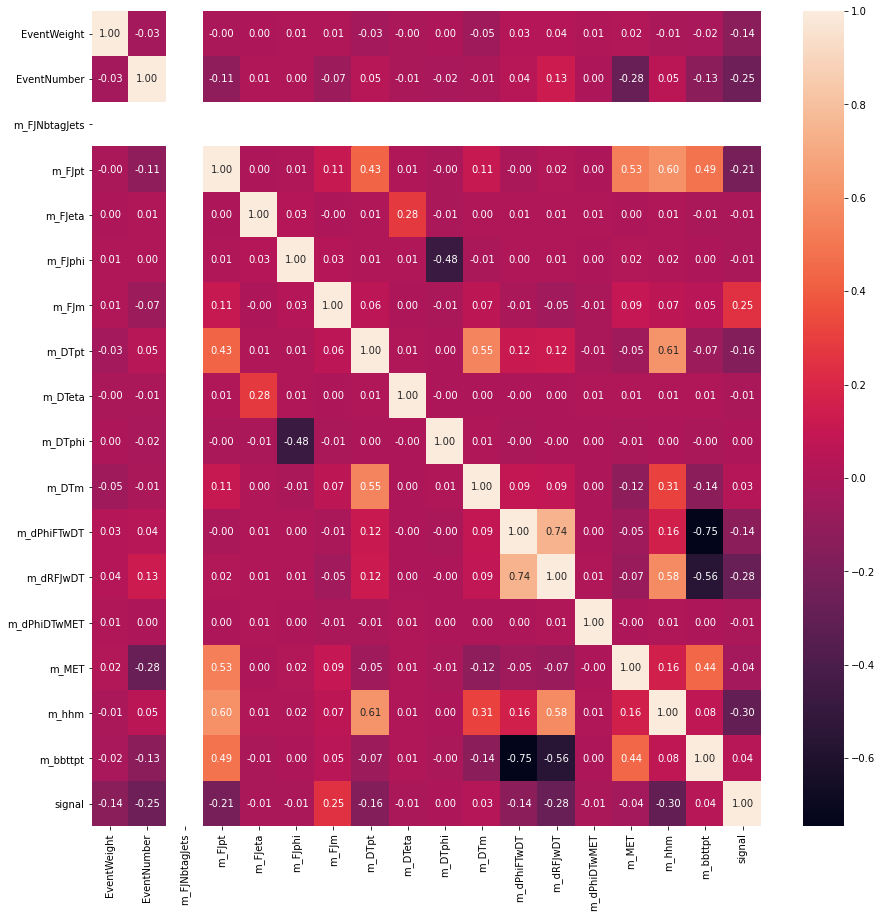

In [12]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

In [13]:
# Delete columns
not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']
df.drop(not_cons, axis=1, inplace=True)

In [14]:
df["signal"].value_counts()

0    9262
1    3553
Name: signal, dtype: int64

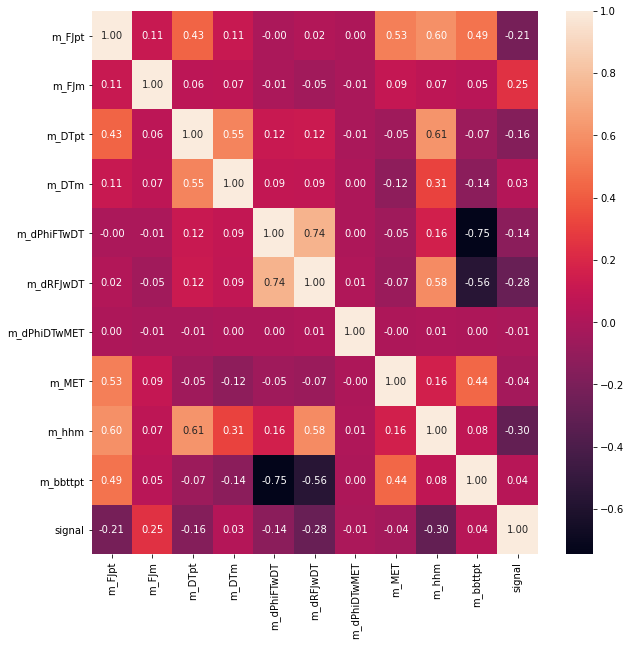

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

In [16]:
df.columns

Index(['m_FJpt', 'm_FJm', 'm_DTpt', 'm_DTm', 'm_dPhiFTwDT', 'm_dRFJwDT',
       'm_dPhiDTwMET', 'm_MET', 'm_hhm', 'm_bbttpt', 'signal'],
      dtype='object')

## Training

X.shape (12815, 10) y.shape (12815,)


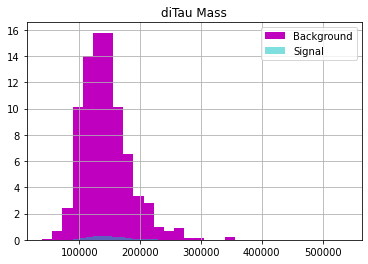

In [14]:
# Features
#feature_cols = df.columns.values[:-1]
#X = df.loc[:, feature_cols].values
df_X = df.drop(columns=["signal"])
feature_cols = df_X.columns.values#everything but the singal
X = df_X.values

# Targets
y = df['signal'].values

print("X.shape", X.shape, "y.shape", y.shape)

weights_sig = weights[y==1]
weights_back = weights[y==0]
weights_squares = weights*weights

diTauMass = df["m_DTm"].values
diTauMass_sig = diTauMass[y==1]
diTauMass_back = diTauMass[y==0]

weights_sq_sig = weights_squares[y==1]
weights_sq_back = weights_squares[y==0]

plt.figure()
plt.title("diTau Mass")
plt.hist(diTauMass_back, weights=weights_back, color="m", bins=30,label="Background")
plt.hist(diTauMass_sig,weights=weights_sig, color="c",alpha=0.5, bins=30, label="Signal")
plt.legend(loc="best")
plt.grid()
plt.show()

In [15]:
sig_sum = weights_sig.sum()
back_sum = weights_back.sum()
tot = sig_sum + back_sum
print("signal -->", sig_sum, round(sig_sum/tot,2)*100,"%")
print("background -->", back_sum, round(back_sum/tot,2)*100,"%")

signal --> 2.2694044 2.9999999329447746 %
background --> 84.66617 97.00000286102295 %


In [16]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
W = np.reshape(weights,(weights.shape[0],1))
print(X_scaled.shape, W.shape)

# X_temp with the EventsWeights, which are not considered for scaling
# but necessary for getting EventsWeights separated by training and
# testing, using train_test_split()
X_temp = np.concatenate((X_scaled,W[:]), axis=1)
print(X_temp.shape)

(12815, 10) (12815, 1)
(12815, 11)


In [17]:
X_train_t, X_test_t, y_train, y_test = train_test_split(X_temp, y, test_size=0.2)
print("-->", X_temp.shape)

X_train = X_train_t[:,0:-1]
X_test = X_test_t[:,0:-1]

print("X_train_t.shape:",X_train_t.shape,"X_test_t.shape",X_test_t.shape)
print("X_train.shape:", X_train.shape, "X_test.shape:",X_test.shape)

train_weights = X_train_t[:,-1]
test_weights = X_test_t[:,-1]

#X_train, y_train = ADASYN().fit_resample(X, y)

print("Training size:",X_train.shape[0])
print("Test size:", X_test.shape[0])
values, counts = np.unique(y, return_counts=True)
print("Signal amount:", counts[1],",", round(counts[1]/y.shape[0], 2),"%")
print("Background amount:", counts[0],",", round(counts[0]/y.shape[0], 2),"%")

--> (12815, 11)
X_train_t.shape: (10252, 11) X_test_t.shape (2563, 11)
X_train.shape: (10252, 10) X_test.shape: (2563, 10)
Training size: 10252
Test size: 2563
Signal amount: 3553 , 0.28 %
Background amount: 9262 , 0.72 %


In [18]:
values_s, count_s = np.unique(y_train, return_counts=True)
print("Signal training events:", count_s[1],",", round(count_s[1]/X_train.shape[0], 2),"%")
print("Background training events:", count_s[0],",", round(count_s[0]/X_train.shape[0],2),"%")
values_b, count_b = np.unique(y_test, return_counts=True)
print("Signal testing events:", count_b[1],",", round(count_b[1]/X_test.shape[0],2),"%")
print("Background testing events:", count_b[0],",", round(count_b[0]/X_test.shape[0],2),"%")

Signal training events: 2884 , 0.28 %
Background training events: 7368 , 0.72 %
Signal testing events: 669 , 0.26 %
Background testing events: 1894 , 0.74 %


In [19]:
def recall_(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_(y_true, y_pred):
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Network

In [20]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform', input_dim=10))
classifier.add(Dropout(rate= 0.1))
#Second  Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Third  Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Fourth Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Fifth Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))

2020-04-08 01:23:50.025751: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-08 01:23:50.057956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-04-08 01:23:50.059202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2020-04-08 01:23:50.059299: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-04-08 01:23:50.059433: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-04-08 01:23:50.063106: I tensorflow/stream_executor/platform/def

### Compile

In [21]:
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =["accuracy"])

In [22]:
print(X_train.shape)
print(y_train.sum())
clf_name = "imb_SR1_acc_batch_100_epochs_200"

(10252, 10)
2884


### Fitting

In [23]:
#Fitting the data to the training dataset
classifier.fit(X_train,y_train, batch_size=100, epochs=150,sample_weight=train_weights)

Epoch 1/150
10252/10252 [==============================] - 5s 517us/step - loss: 0.0024 - accuracy: 0.7179
Epoch 2/150
10252/10252 [==============================] - 1s 58us/step - loss: 8.3664e-04 - accuracy: 0.7187
Epoch 3/150
10252/10252 [==============================] - 1s 66us/step - loss: 8.1854e-04 - accuracy: 0.7187
Epoch 4/150
10252/10252 [==============================] - 1s 65us/step - loss: 7.8735e-04 - accuracy: 0.7187
Epoch 5/150
10252/10252 [==============================] - 1s 58us/step - loss: 7.7390e-04 - accuracy: 0.7187
Epoch 6/150
10252/10252 [==============================] - 0s 44us/step - loss: 7.7035e-04 - accuracy: 0.7187
Epoch 7/150
10252/10252 [==============================] - 1s 52us/step - loss: 7.6253e-04 - accuracy: 0.7187
Epoch 8/150
10252/10252 [==============================] - 0s 45us/step - loss: 7.5916e-04 - accuracy: 0.7187
Epoch 9/150
10252/10252 [==============================] - 1s 58us/step - loss: 7.6734e-04 - accuracy: 0.7187
Epoch 10/150


2020-04-08 01:24:14.185706: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


### Predicting

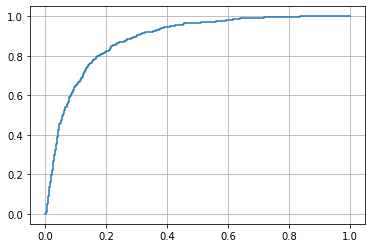

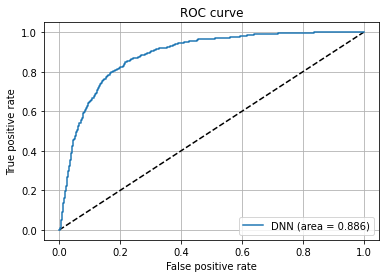

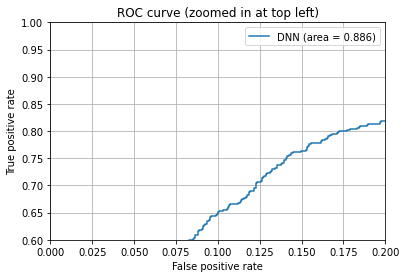

In [24]:
y_pred_prob = classifier.predict(X_test)
y_pred = (y_pred_prob>0.5)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
#np.save("jjcc2019_results/" + clf_name+"_fpr_roc.npy",fpr)
#np.save("jjcc2019_results/" + clf_name+"_tpr_roc.npy",tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.grid()
plt.show()
roc_auc_s = roc_auc_score(y_test, y_pred_prob)
#np.save("jjcc2019_results/" + clf_name +"_roc_auc.npy",roc_auc_s)

#https://github.com/Tony607/ROC-Keras/blob/master/ROC-Keras.ipynb
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='DNN (area = {:.3f})'.format(roc_auc_s))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='DNN (area = {:.3f})'.format(roc_auc_s))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.grid()
plt.show()

In [25]:
r = recall_score(y_test,y_pred)
p = precision_score(y_test,y_pred)
a = accuracy_score(y_test,y_pred)

print("recall:", r)
print("precision:", p)
print("accuracy:", a)

recall: 0.0343796711509716
precision: 0.696969696969697
accuracy: 0.7440499414748342


In [26]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1884   10]
 [ 646   23]]


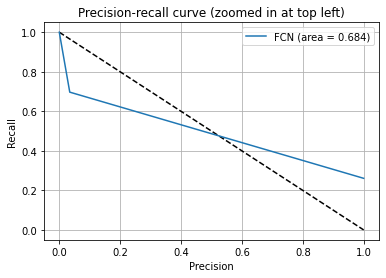

In [27]:
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred)
#np.save("jjcc2019_results/" + clf_name+"_prec_.npy",precision)
#np.save("jjcc2019_results/" + clf_name+"_rec_.npy",recall)
prec_rec_auc = average_precision_score(y_test, y_pred_prob)
#np.save("jjcc2019_results/" + clf_name+"_pc_auc.npy",prec_rec_auc)

plt.figure()
plt.plot([0, 1], [1, 0], 'k--')
plt.plot(recall, precision, label='FCN (area = {:.3f})'.format(prec_rec_auc))
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-recall curve (zoomed in at top left)')
plt.legend(loc='best')
plt.grid()
plt.show()